In [1]:
import sys
# sys.path.append(r"Y:\Users\Yingyue\Gates_Lab_Suite-master")
sys.path.append(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master")
from Core_Definition import *
from Auto_Algorithm import *
from Visualization import *
import os
from SPAM import *
import numpy as np
import xlsxwriter as xlsx
from scipy import optimize
import random
import math
from math import floor
import pickle
import uuid

In [2]:
import json, pickle
import qiskit
#transpiler reducinig qiskit circuit to QASM strings
from qiskit import transpile
# Use AerSimulator
from qiskit_aer import AerSimulator
from qiskit import IBMQ, QuantumCircuit, execute
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info import Pauli, Clifford, Statevector,Operator
from qiskit.visualization import array_to_latex
from scipy.stats import sem, unitary_group
from scipy.linalg import sqrtm,expm
import qiskit.quantum_info as qi
from qiskit.quantum_info import Pauli
import pylatexenc

In [3]:
from scipy.optimize import curve_fit
from copy import copy, deepcopy
def rcs_fit_fun_depth1(x, alpha):
        #return a * np.exp(-alpha * x)
        return alpha ** x

def fit_EAB_depth1(X, xeb_list):
    Y = [np.mean(xeb_list[L]) for L in X]
    Yerr = [sem(xeb_list[L]) for L in X]
    #print(linregress(X,np.log(Y)))
    
    
    try:
        params, pcov = curve_fit(rcs_fit_fun_depth1, X, Y, sigma=Yerr, absolute_sigma=True, p0=[1])
        alpha = params[0]
        params_err = np.sqrt(np.diag(pcov))
        alpha_err = params_err[0]

    except RuntimeError:
        alpha = 1.0
        alpha_err = 0.0


    return alpha, alpha_err

    print(alpha, alpha_err)

def int_to_pauli(i,n):
    p = np.base_repr(i,base=4)
    p = '0'*(n-len(p)) + p
    p = p.replace('0','I').replace('1', 'X').replace('2', 'Y').replace('3', 'Z')
    return p

def commute(p,q):
    c = 1
    n = len(p)
    for i in range(n):
        if p[i] != 'I' and q[i] != 'I':
            if p[i] != q[i]:
                c *= -1
    return c

def fidelity_to_error(pauli_fidelity,n):
    N = 4**n
    pauli_error = {}
    for i in range(N):
        p = int_to_pauli(i,n)
        pauli_error[p] = 0
        for j in range(N):
            q = int_to_pauli(j,n)
            pauli_error[p] += pauli_fidelity[q] * commute(p,q) / N
    return pauli_error
    

In [4]:
import random   

#only eliminate one element in bootstrapping
def bootstrap_fit_EAB_plot(X, xeb_list):
    full_list=deepcopy(xeb_list)
    alpha_rtn_frm_fit=[0]*10
    alpha_err_rtn_frm_fit=[0]*10
    a_rtn_frm_fit=[0]*10
    Y_rtn_frm_fit=[0]*10
    Yerr_rtn_frm_fit=[0]*10
    for i in range (10):
        xeb_list_temp=deepcopy(full_list)
        for j in X:
            r=random.randint(0, 19)
#             print ("before random removal", len(xeb_list_temp[j]))
            xeb_list_temp[j].remove(xeb_list_temp[j][r])
#             print ("after random removal", len(xeb_list_temp[j]))
            assert len(xeb_list_temp[j])==19
#         print (i)
        alpha_rtn_frm_fit[i], a_rtn_frm_fit[i],alpha_err_rtn_frm_fit[i],Y_rtn_frm_fit[i],Yerr_rtn_frm_fit[i]= fit_EAB_plot(X, xeb_list_temp)
#         print (alpha_rtn_frm_fit[i])
    alpha_bootstrap=np.mean(alpha_rtn_frm_fit)
    alpha_err_bootstrap=np.std(alpha_rtn_frm_fit)
    return alpha_bootstrap,alpha_err_bootstrap, alpha_rtn_frm_fit,a_rtn_frm_fit, alpha_err_rtn_frm_fit,Y_rtn_frm_fit,Yerr_rtn_frm_fit
    
#specify number of elements to resample : rs
def bootstrap_fit_EAB_plot_rs(X, xeb_list,rs):
    full_list=deepcopy(xeb_list)        
    alpha_rtn_frm_fit=[0]*10
    alpha_err_rtn_frm_fit=[0]*10
    a_rtn_frm_fit=[0]*10
    Y_rtn_frm_fit=[0]*10
    Yerr_rtn_frm_fit=[0]*10
    for i in range (10):
        xeb_list_temp=deepcopy(full_list)
        for j in X:
#             print ("before random removal", len(xeb_list_temp[j]))
            for m in range (20-rs):
                r=random.randint(0,20-m-1)
#                 r=random.sample(range(20), 20-rs)
                xeb_list_temp[j].remove(xeb_list_temp[j][r])
#             print ("after random removal", len(xeb_list_temp[j]))
            assert len(xeb_list_temp[j])==rs
        print ("i,j",i,j)
        alpha_rtn_frm_fit[i], a_rtn_frm_fit[i],alpha_err_rtn_frm_fit[i],Y_rtn_frm_fit[i],Yerr_rtn_frm_fit[i]= fit_EAB_plot(X, xeb_list_temp)
#         print (alpha_rtn_frm_fit[i])
    alpha_bootstrap=np.mean(alpha_rtn_frm_fit)
    alpha_err_bootstrap=np.std(alpha_rtn_frm_fit)
    return alpha_bootstrap,alpha_err_bootstrap, alpha_rtn_frm_fit,a_rtn_frm_fit, alpha_err_rtn_frm_fit,Y_rtn_frm_fit,Yerr_rtn_frm_fit



In [5]:
# filename = str(uuid.uuid4())
# filename+="XX23541_noSE_explicitCNOT_XX_R_0711_01+10_ExperimentalData"
with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/EAB_identity_channel/results_file/6e9b3d83-c000-409b-9731-7d059c29bdd4XX23541_FTXX_identitychannel_01152024_01+10_ExperimentalData", "rb") as fp:
    eab_load_cpy=pickle.load(fp)

In [6]:
sys.path.append(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation")
import EAB_process_modified 
import itertools
import pdb

'''Specify a set of Pauli you want to estimate'''
# C=10
C=20
nqubit=2
depth=[2,4,8,16,32]
pauli_request_list = [''.join(s) for s in itertools.product(['I','X','Y','Z'], repeat = nqubit)] #full

#process_EAB(Lrange, cb_data, pauli_request_list)
eab_result=EAB_process_modified.process_EAB_01_identitytest(depth, eab_load_cpy, pauli_request_list)
# eab_result_spam=EAB_process_modified.process_EAB(depth, eab_load_cpy_spam, pauli_request_list)

print (eab_result)


{'fidelity_list': {'II': {2: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 4: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 8: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 16: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 32: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, 'IX': {2: [0.833, 0.94, 0.926, 0.883, 0.82, 0.925, 0.799, 0.822, 0.794, 0.641, 0.809, 0.829, 0.709, 0.809, 0.879, 0.903, 0.69, 0.827, 0.923, 0.915], 4: [0.811, 0.873, 0.791, 0.781, 0.897, 0.931, 0.773, 0.785, 0.681, 0.779, 0.673, 0.911, 0.787, 0.727, 0.881, 0.85, 0.866, 0.744, 0.86, 0.861], 8: [0.726, 0.67, 0.765, 0.632, 0.631, 0.646, 0.745, 0.75, 0.664, 0.729, 0.799, 0.788, 0.652, 0.8, 0.747, 0.705, 0.865, 0.712, 0.849, 0.681], 16: [0.396, 0

Data analysis

In [7]:
raw_fidelity_list = eab_result["fidelity_list"]

#######depth=[2]#########
##########################
plot_dic={}
error_dic={}
err=[]
# sys.exit(0)
depth=[2]
fidelity_list = {}
stdev_list = {}

for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha, alpha_err = fit_EAB_depth1(depth, raw_fidelity_list[pauli_label])
        fidelity_list[pauli_label] = alpha
        stdev_list[pauli_label] = alpha_err

# print(fidelity_list)

# print(stdev_list)

print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
shots=2000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], 1-fidelity_list[pauli_label], stdev_list[pauli_label])
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
    plot_dic[pauli_label[::-1]]=1-fidelity_list[pauli_label]
    error_dic[pauli_label[::-1]]=stdev_list[pauli_label]
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))

plot_2={}
plot_2=deepcopy(plot_dic)
err_2=deepcopy(error_dic)

#######depth=[2]#########
##########################
plot_dic={}
err=[]
# sys.exit(0)
depth=[2,4]
fidelity_list = {}
stdev_list = {}

for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha, alpha_err = EAB_process_modified.fit_EAB(depth, raw_fidelity_list[pauli_label])
        fidelity_list[pauli_label] = alpha
        stdev_list[pauli_label] = alpha_err

# print(fidelity_list)

# print(stdev_list)

print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
shots=2000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], 1-fidelity_list[pauli_label], stdev_list[pauli_label])
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
    plot_dic[pauli_label[::-1]]=1-fidelity_list[pauli_label]
    error_dic[pauli_label[::-1]]=stdev_list[pauli_label]
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))

plot_24={}
plot_24=deepcopy(plot_dic)
err_24=deepcopy(error_dic)

#######depth=[2]#########
##########################
plot_dic={}
error_dic={}
error_dic={}
err=[]
# sys.exit(0)
depth=[2,4,8]
fidelity_list = {}
stdev_list = {}

for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha, alpha_err = EAB_process_modified.fit_EAB(depth, raw_fidelity_list[pauli_label])
        fidelity_list[pauli_label] = alpha
        stdev_list[pauli_label] = alpha_err

# print(fidelity_list)

# print(stdev_list)

print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
shots=2000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], 1-fidelity_list[pauli_label], stdev_list[pauli_label])
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
    plot_dic[pauli_label[::-1]]=1-fidelity_list[pauli_label]
    error_dic[pauli_label[::-1]]=stdev_list[pauli_label]
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))

plot_248={}
plot_248=deepcopy(plot_dic)
err_248=deepcopy(error_dic)


Parameters: n = 2, C = 20,  L =  [2]
Measurement based simulation, shots = 2000
No readout error
Total error =  0.10089931205262859
Label / Pauli infidelity / Standard deviation
II 0.0 0.0
XI 0.08687350273907823 0.010118114776047973
YI 0.09178746980676378 0.010328298032748134
ZI 0.03877682092034429 0.0022183131009672714
IX 0.08777743943706373 0.008136643634911381
XX 0.15522192263293189 0.010550409958275449
YX 0.15982144754820116 0.01027103224686392
ZX 0.11926167336716864 0.007483689620200737
IY 0.08780484544150313 0.007752306795361034
XY 0.15525151672228488 0.010095407808559786
YY 0.15889953037701854 0.009580367987351998
ZY 0.1178152121012287 0.007308730619118118
IZ 0.039505335777444195 0.0026673631185814293
XZ 0.11968755546681042 0.01035265662124828
YZ 0.1236439079917343 0.010642481019462188
ZZ 0.07226081251248206 0.003859167157380275
Parameters: n = 2, C = 20,  L =  [2, 4]
Measurement based simulation, shots = 2000
No readout error
Total error =  0.012552434439723426
Label / Pauli in

In [8]:
def rcs_fit_fun(x, a, alpha):
        #return a * np.exp(-alpha * x)
        return a * (alpha ** x)

def fit_EAB_plot(X, xeb_list):
    Y = [np.mean(xeb_list[L]) for L in X]
    Yerr = [sem(xeb_list[L]) for L in X]
    #print(linregress(X,np.log(Y)))
    
    
    try:
        params, pcov = curve_fit(rcs_fit_fun, X, Y, sigma=Yerr, absolute_sigma=True, p0=[1,1])
        alpha = params[1]
        a=params[0]
        params_err = np.sqrt(np.diag(pcov))
        alpha_err = params_err[1]

    except RuntimeError:
        alpha = 1.0
        alpha_err = 0.0

    # params, pcov = curve_fit(rcs_fit_fun, X, Y, sigma=Yerr, absolute_sigma=True, p0=[1,1])
    # #params, pcov = curve_fit(rcs_fit_fun, X, Y, absolute_sigma=True, p0=[1,1])


    # print(params)

    return alpha,a, alpha_err,Y, Yerr

    print(alpha, alpha_err)



plot average fidelity and fit

Parameters: n = 2, C = 20,  L =  [2, 4, 8, 16, 32]
Measurement based simulation, shots = 2000
No readout error
Total error =  0.020775356682823598
Label / Pauli infidelity / Standard deviation
II 0.0 0.0
XI 0.0197238 0.0019712
YI 0.0177217 0.0015327
ZI 0.0079675 0.0008611
IX 0.0189753 0.0014404
XX 0.0363888 0.0022507
YX 0.0354962 0.0021225
ZX 0.0257269 0.0015447
IY 0.0186966 0.0014041
XY 0.0362712 0.0022173
YY 0.035517 0.002019
ZY 0.0253372 0.0014838
IZ 0.0027731 0.0003529
XZ 0.0219661 0.0020556
YZ 0.0201394 0.0016272
ZZ 0.0097049 0.0009465
{'IX': [0.8338000000000001, 0.8131, 0.7278, 0.62655, 0.4769], 'IY': [0.82485, 0.8253999999999999, 0.7558499999999999, 0.61735, 0.5107999999999999], 'IZ': [0.9239499999999999, 0.8941000000000001, 0.84095, 0.8277000000000001, 0.7418], 'XI': [0.8321499999999998, 0.8238, 0.76745, 0.6829000000000001, 0.4024], 'XX': [0.7136500000000001, 0.6829, 0.57035, 0.44675000000000004, 0.22559999999999997], 'XY': [0.7059, 0.6895, 0.5958000000000001, 0.43945, 0.235700

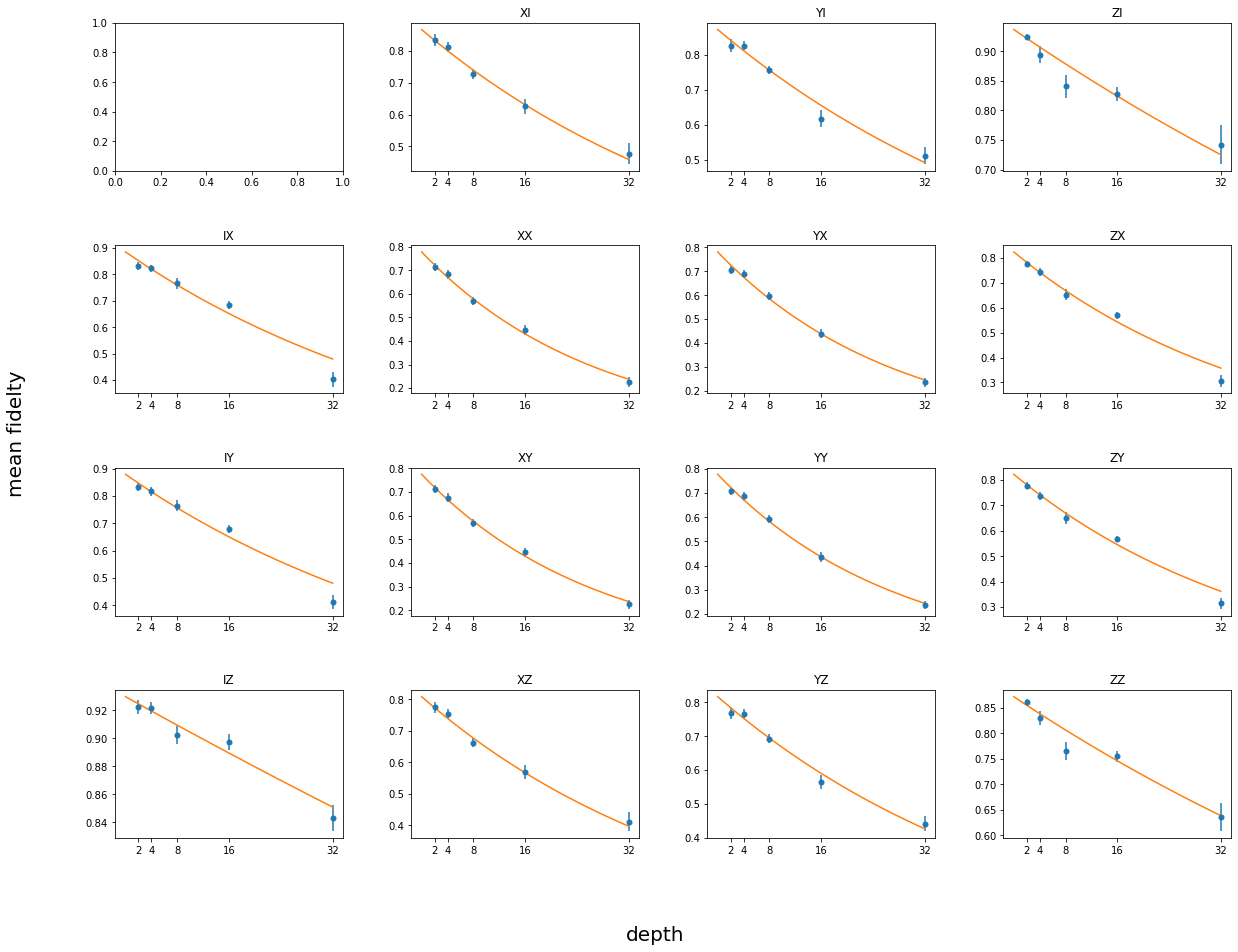

In [9]:
raw_fidelity_list = eab_result["fidelity_list"]
plot_dic={}
error_dic={}
# sys.exit(0)
depth=[2,4,8,16,32]
fidelity_list = {}
stdev_list = {}
a248_dic={}
Y248_dic={}
Yerr248_dic={}
for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha,a, alpha_err,Y, Yerr = fit_EAB_plot(depth, raw_fidelity_list[pauli_label])
        fidelity_list[pauli_label] = alpha #pauli fidelity from fit
        stdev_list[pauli_label] = alpha_err #error on pauli fidelity from fit
        a248_dic[pauli_label]=a 
        Y248_dic[pauli_label]=Y
        Yerr248_dic[pauli_label]=Yerr

print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
shots=2000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], round(1-fidelity_list[pauli_label],7), round(stdev_list[pauli_label],7))
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
    plot_dic[pauli_label[::-1]]=1-fidelity_list[pauli_label]
    error_dic[pauli_label[::-1]]=stdev_list[pauli_label]
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
# for pauli_label in pauli_request_list:
#     print(pauli_label[::-1], fidelity_list[pauli_label])

plot_248={}
plot_248=deepcopy(plot_dic)
err_248=deepcopy(error_dic)
print (Y248_dic)

x_c=np.linspace(0,32,num=80)
nqubit=2
fig, axs = plt.subplots(4, 4)
fig.set_figwidth(20)
fig.set_figheight(15)
fig.subplots_adjust(hspace=0.5,wspace=0.3) 
fig.text(0.5, 0.03, 'depth', ha='center',fontsize=20)
fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
for i in range (4):
    for j in range(4):
        pauli_label=pauli_request_list[4*i+j]
        if (pauli_label == 'I'*nqubit):
#                 fidelity_list[pauli_label] = 1.0
#                 stdev_list[pauli_label] = 0.0
            pass
        else:
            axs[i, j].set_xticks([2,4,8,16,32])   
            axs[i, j].errorbar(depth,Y248_dic[pauli_label], yerr=Yerr248_dic[pauli_label], fmt='o',markersize=5)
            axs[i, j].plot(x_c,rcs_fit_fun(x_c,a248_dic[pauli_label], fidelity_list[pauli_label]))
            axs[i, j].set_title(pauli_label[::-1])
                
# for pauli_label in pauli_request_list:
# fig.savefig("fit.pdf", format="pdf", dpi=500)        

plot fidelity from each circuit and fit

In [10]:
error_list = fidelity_to_error(fidelity_list,nqubit)
print("Label / Pauli error rates")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], round(error_list[pauli_label],7))


Label / Pauli error rates
II 0.9792246
XI 0.001426
YI 0.0021104
ZI 0.0071277
IX 0.0005253
XX 5.2e-05
YX 9.13e-05
ZX -4.51e-05
IY 0.000621
XY 5.55e-05
YY 6.01e-05
ZY 2.64e-05
IZ 0.0082758
XZ -4.22e-05
YZ 0.0002306
ZZ 0.0002605


Parameters: n = 2, C = 20,  L =  [2, 4, 8, 16, 32]
Measurement based simulation, shots = 2000
No readout error
Total error =  0.020775356682823598
Label / Pauli infidelity / Standard deviation
II 0.0 0.0
XI 0.019723826895310714 0.001971162615205957
YI 0.01772165566212669 0.0015326526723491052
ZI 0.007967505761641624 0.0008610765138290533
IX 0.01897532279739733 0.0014403985449205215
XX 0.036388827398090906 0.002250720014289251
YX 0.03549615724672461 0.0021224954455919096
ZX 0.02572690068765715 0.0015447222363042974
IY 0.018696629976240886 0.0014040540701107562
XY 0.03627118442638333 0.00221732972627168
YY 0.03551698428561134 0.0020190342576410646
ZY 0.025337188709902203 0.0014837757690884259
IZ 0.002773112509325326 0.0003529273832808836
XZ 0.021966063324685314 0.0020556060330685503
YZ 0.020139412934659595 0.0016271784414065998
ZZ 0.009704934309420987 0.0009464814521783205
{'IX': [0.8338000000000001, 0.8131, 0.7278, 0.62655, 0.4769], 'IY': [0.82485, 0.8253999999999999, 0.7558499999999999

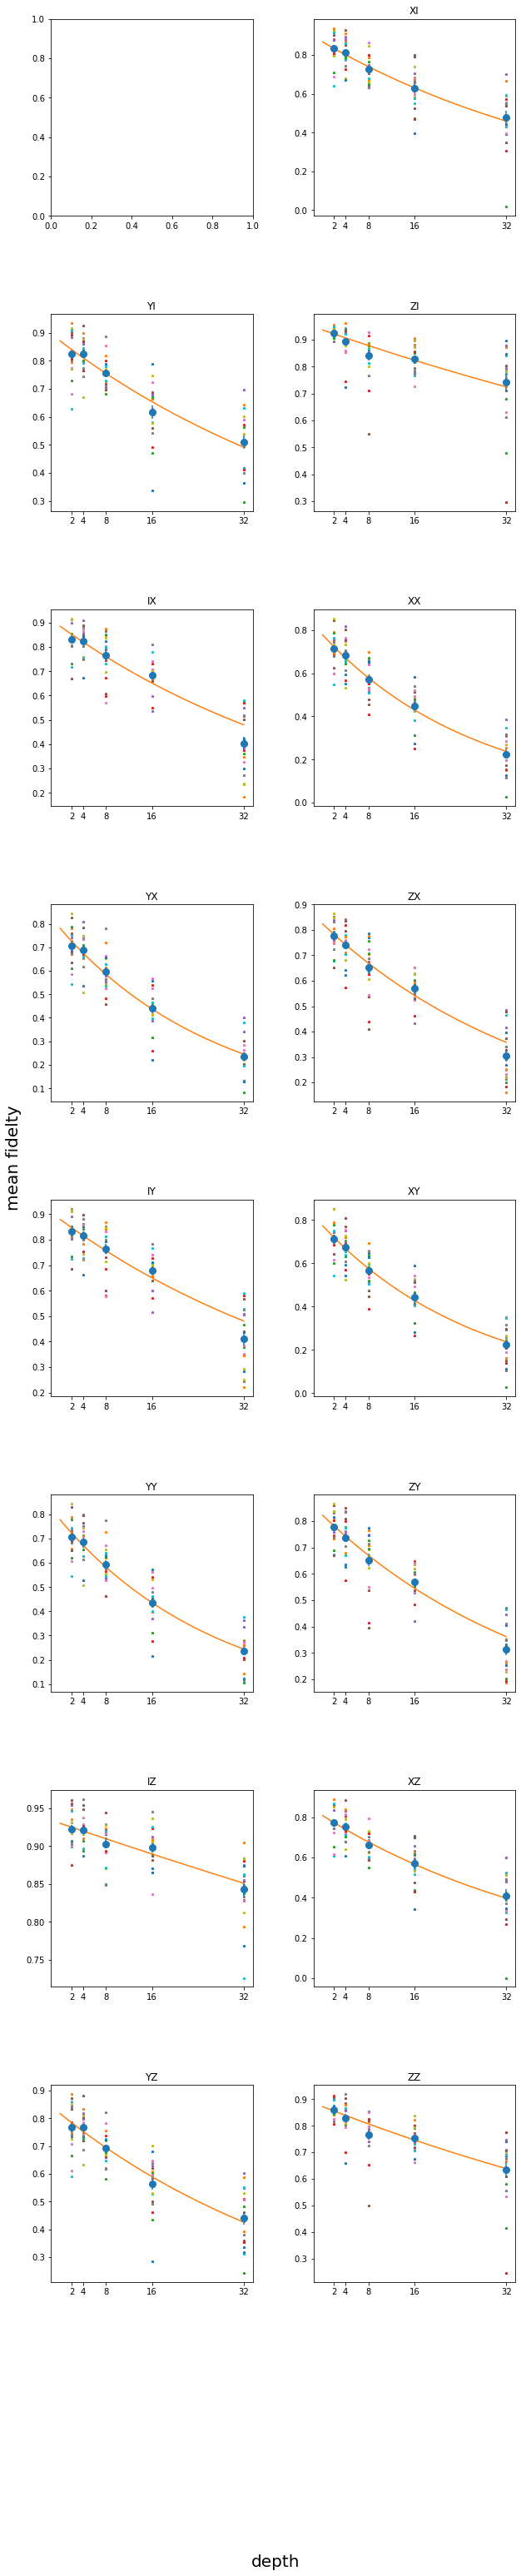

In [11]:
raw_fidelity_list = eab_result["fidelity_list"]
plot_dic={}
error_dic={}
# sys.exit(0)
depth=[2,4,8,16,32]
fidelity_list = {}
stdev_list = {}
a248_dic={}
Y248_dic={}
Yerr248_dic={}
for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha,a, alpha_err,Y, Yerr = fit_EAB_plot(depth, raw_fidelity_list[pauli_label])
        fidelity_list[pauli_label] = alpha #pauli fidelity from fit
        stdev_list[pauli_label] = alpha_err #error on pauli fidelity from fit
        a248_dic[pauli_label]=a 
        Y248_dic[pauli_label]=Y
        Yerr248_dic[pauli_label]=Yerr

print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
shots=2000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], 1-fidelity_list[pauli_label], stdev_list[pauli_label])
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
    plot_dic[pauli_label[::-1]]=1-fidelity_list[pauli_label]
    error_dic[pauli_label[::-1]]=stdev_list[pauli_label]
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
# for pauli_label in pauli_request_list:
#     print(pauli_label[::-1], fidelity_list[pauli_label])

plot_248={}
plot_248=deepcopy(plot_dic)
err_248=deepcopy(error_dic)
print (Y248_dic)

x_c=np.linspace(0,32,num=80)
nqubit=2
fig, axs = plt.subplots(8, 2)
fig.set_figwidth(10)
fig.set_figheight(50)
fig.subplots_adjust(hspace=0.5,wspace=0.3) 
fig.text(0.5, 0.03, 'depth', ha='center',fontsize=20)
fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
for i in range (8):
    for j in range(2):
        pauli_label=pauli_request_list[2*i+j]
        if (pauli_label == 'I'*nqubit):
#                 fidelity_list[pauli_label] = 1.0
#                 stdev_list[pauli_label] = 0.0
            pass
        else:
            axs[i, j].set_xticks([2,4,8,16,32])   
#             axs[i, j].errorbar(depth,Y248_dic[pauli_label], yerr=Yerr248_dic[pauli_label], fmt='o',markersize=5)
            print ([tuple(eab_result['fidelity_list'][pauli_label][2])])
#             axs[i, j].plot([2],[tuple(eab_result['fidelity_list'][pauli_label][2])],"*",markersize=3)
#             axs[i, j].plot([4],[tuple(eab_result['fidelity_list'][pauli_label][4])],"*",markersize=3)
#             axs[i, j].plot([8],[tuple(eab_result['fidelity_list'][pauli_label][8])],"*",markersize=3)
#             axs[i, j].plot([16],[tuple(eab_result['fidelity_list'][pauli_label][16])],"*",markersize=3)
#             axs[i, j].plot([32],[tuple(eab_result['fidelity_list'][pauli_label][32])],"*",markersize=3)
            axs[i, j].plot(depth,[tuple(eab_result['fidelity_list'][pauli_label][L]) for L in depth],"*",markersize=3)
            axs[i, j].errorbar(depth,Y248_dic[pauli_label], yerr=Yerr248_dic[pauli_label], fmt='o',markersize=8)
            axs[i, j].plot(x_c,rcs_fit_fun(x_c,a248_dic[pauli_label], fidelity_list[pauli_label]))
            axs[i, j].set_title(pauli_label[::-1])
                
# for pauli_label in pauli_request_list:
# fig.savefig("fit.pdf", format="pdf", dpi=500)        

data analysis with bootstrapping

Parameters: n = 2, C = 20,  L =  [2, 4, 8, 16, 32]
Measurement based simulation, shots = 2000
No readout error
Total error =  0.020749257813476807
XI 0.0191817 0.0015141
YI 0.0180088 0.0004543
ZI 0.0076725 0.0006622
IX 0.0187383 0.0012884
XX 0.0369175 0.0010795
YX 0.0354555 0.0009849
ZX 0.0256526 0.0012214
IY 0.0184361 0.0010825
XY 0.0366103 0.0009662
YY 0.0356554 0.0015757
ZY 0.0252494 0.0012542
IZ 0.0028515 0.0002251
XZ 0.021938 0.0014235
YZ 0.0201334 0.0008147
ZZ 0.0094872 0.0005286
[0.9897320900832002, 0.9900841154690466, 0.9900261337182681, 0.9904842495114432, 0.9913436629165319, 0.9904798957603593, 0.9903674666236859, 0.9902493341016211, 0.9913914105190412, 0.9909698270204231]


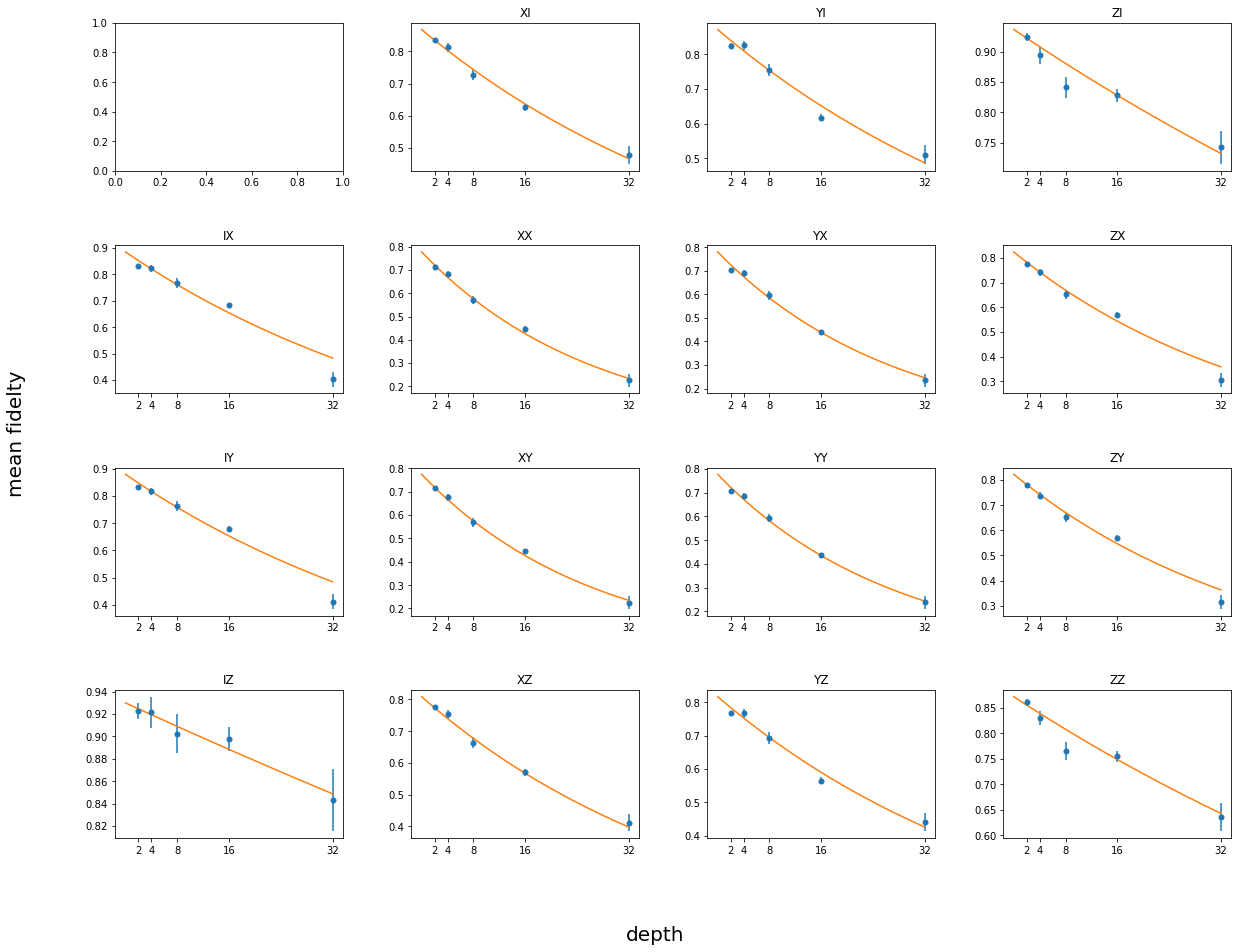

In [12]:
import bootstrap

raw_fidelity_list = eab_result["fidelity_list"]
plot_dic={}
error_dic={}
# sys.exit(0)
depth=[2,4,8,16,32]
fidelity_list = {}
stdev_list = {}
alpha_detail={}
a_detail={}
alpha_error_detail={}
Y_detail={}
Y_err_detail={}
# a248_dic={}
# Y248_dic={}
# Yerr248_dic={}
for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha_bootstrap,alpha_err_bootstrap, alpha_rtn_frm_fit,a_rtn_frm_fit, alpha_err_rtn_frm_fit,Y_rtn_frm_fit,Yerr_rtn_frm_fit = bootstrap.bootstrap_fit_EAB_plot_rs(depth, raw_fidelity_list[pauli_label],15)
        fidelity_list[pauli_label] = alpha_bootstrap #pauli fidelity from fit
        stdev_list[pauli_label] = alpha_err_bootstrap #error on pauli fidelity from fit
#         a248_dic[pauli_label]=a 
#         Y248_dic[pauli_label]=Y
        Yerr248_dic[pauli_label]=Yerr
        alpha_detail[pauli_label]=alpha_rtn_frm_fit
        alpha_error_detail[pauli_label]=alpha_err_rtn_frm_fit
        Y_detail[pauli_label]=Y_rtn_frm_fit
        Y_err_detail[pauli_label]=Yerr_rtn_frm_fit

        
print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
shots=2000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))        
for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        continue
    else:
        print (pauli_label[::-1],round(1-fidelity_list[pauli_label],7),round(stdev_list[pauli_label],7))

print (alpha_detail[pauli_label])


x_c=np.linspace(0,32,num=80)
nqubit=2
fig, axs = plt.subplots(4, 4)
fig.set_figwidth(20)
fig.set_figheight(15)
fig.subplots_adjust(hspace=0.5,wspace=0.3) 
fig.text(0.5, 0.03, 'depth', ha='center',fontsize=20)
fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
for i in range (4):
    for j in range(4):
        pauli_label=pauli_request_list[4*i+j]
        if (pauli_label == 'I'*nqubit):
#                 fidelity_list[pauli_label] = 1.0
#                 stdev_list[pauli_label] = 0.0
            pass
        else:
            axs[i, j].set_xticks([2,4,8,16,32])   
            axs[i, j].errorbar(depth,Y248_dic[pauli_label], yerr=Yerr248_dic[pauli_label], fmt='o',markersize=5)
            axs[i, j].plot(x_c,rcs_fit_fun(x_c,a248_dic[pauli_label], fidelity_list[pauli_label]))
            axs[i, j].set_title(pauli_label[::-1])
# x_c=np.linspace(0,32,num=80)
# nqubit=2
# fig, axs = plt.subplots(8, 2)
# fig.set_figwidth(10)
# fig.set_figheight(50)
# fig.subplots_adjust(hspace=0.5,wspace=0.3) 
# fig.text(0.5, 0.03, 'depth', ha='center',fontsize=20)
# fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
# for i in range (8):
#     for j in range(2):
#         pauli_label=pauli_request_list[2*i+j]
#         if (pauli_label == 'I'*nqubit):
# #                 fidelity_list[pauli_label] = 1.0
# #                 stdev_list[pauli_label] = 0.0
#             pass
#         else:
#             axs[i, j].set_xticks([2,4,8,16,32])   
# #             axs[i, j].errorbar(depth,Y248_dic[pauli_label], yerr=Yerr248_dic[pauli_label], fmt='o',markersize=5)
#             print ([tuple(eab_result['fidelity_list'][pauli_label][2])])
# #             axs[i, j].plot([2],[tuple(eab_result['fidelity_list'][pauli_label][2])],"*",markersize=3)
# #             axs[i, j].plot([4],[tuple(eab_result['fidelity_list'][pauli_label][4])],"*",markersize=3)
# #             axs[i, j].plot([8],[tuple(eab_result['fidelity_list'][pauli_label][8])],"*",markersize=3)
# #             axs[i, j].plot([16],[tuple(eab_result['fidelity_list'][pauli_label][16])],"*",markersize=3)
# #             axs[i, j].plot([32],[tuple(eab_result['fidelity_list'][pauli_label][32])],"*",markersize=3)
#             axs[i, j].plot(depth,[tuple(eab_result['fidelity_list'][pauli_label][L]) for L in depth],"*",markersize=3)
#             axs[i, j].errorbar(depth,Y248_dic[pauli_label], yerr=Yerr248_dic[pauli_label], fmt='o',markersize=8)
#             axs[i, j].plot(x_c,rcs_fit_fun(x_c,a248_dic[pauli_label], fidelity_list[pauli_label]))
#             axs[i, j].set_title(pauli_label[::-1])
                
# # for pauli_label in pauli_request_list:
# # fig.savefig("fit.pdf", format="pdf", dpi=500)      

In [13]:
error_list = fidelity_to_error(fidelity_list,nqubit)
print("Label / Pauli error rates")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], round(error_list[pauli_label],7))


Label / Pauli error rates
II 0.9792507
XI 0.0014151
YI 0.0020894
ZI 0.0072383
IX 0.0005459
XX 7.89e-05
YX 6.33e-05
ZX -5.08e-05
IY 0.0006475
XY 0.0001297
YY -1.27e-05
ZY 2.4e-05
IZ 0.0083401
XZ 1.3e-06
YZ 7.13e-05
ZZ 0.000168


In [14]:
error_list = fidelity_to_error(fidelity_list,nqubit)
print("Label / Pauli error rates")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], error_list[pauli_label])


Label / Pauli error rates
II 0.9792507421865231
XI 0.00141508678666636
YI 0.0020893876671398623
ZI 0.007238317618700411
IX 0.0005459000148125837
XX 7.890002222982195e-05
YX 6.330184427517926e-05
ZX -5.08012271031727e-05
IY 0.0006474900495175365
XY 0.00012966953680179638
YY -1.2684206452284741e-05
ZY 2.3951562431331896e-05
IZ 0.008340127565023558
XZ 1.2520677692695603e-06
YZ 7.13237925852317e-05
ZZ 0.00016803471907943235


In [15]:
print (type(raw_fidelity_list[pauli_label][2]))
print (raw_fidelity_list[pauli_label])

<class 'list'>
{2: [0.843, 0.911, 0.847, 0.806, 0.862, 0.865, 0.827, 0.853, 0.863, 0.851, 0.876, 0.84, 0.844, 0.913, 0.901, 0.907, 0.827, 0.815, 0.864, 0.899], 4: [0.86, 0.865, 0.832, 0.859, 0.856, 0.884, 0.794, 0.919, 0.836, 0.867, 0.659, 0.878, 0.803, 0.701, 0.816, 0.903, 0.813, 0.806, 0.809, 0.839], 8: [0.825, 0.778, 0.798, 0.654, 0.789, 0.5, 0.798, 0.725, 0.741, 0.756, 0.853, 0.815, 0.755, 0.825, 0.742, 0.819, 0.852, 0.764, 0.758, 0.766], 16: [0.675, 0.822, 0.79, 0.772, 0.801, 0.718, 0.661, 0.742, 0.838, 0.732, 0.738, 0.801, 0.739, 0.8, 0.739, 0.753, 0.765, 0.71, 0.795, 0.706], 32: [0.686, 0.705, 0.582, 0.776, 0.711, 0.61, 0.675, 0.678, 0.642, 0.634, 0.742, 0.666, 0.415, 0.245, 0.748, 0.706, 0.535, 0.557, 0.697, 0.692]}


spam results

In [16]:
print (eab_load)

NameError: name 'eab_load' is not defined

In [ ]:
print (type(eab_result["fidelity_list"]["IX"][2]))

In [ ]:
print ([tuple(eab_result['fidelity_list'][pauli_label][2])])
y2=[tuple(eab_result['fidelity_list'][pauli_label][2])]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

y = [(1,1,2,4)]
x = [2]
plt.plot(x,[tuple(eab_result['fidelity_list'][pauli_label][2])],"r*")
plt.show()

In [ ]:

b=[]
c=[1,2]
f=c
c=[1]
print (d)
print (b)
print (c)